AIM分析的是根据电子密度对空间的划分

空间中的每一个点，计算其电子密度Hessian矩阵，然后计算Hessian矩阵的本征值

定义临界点由两个数确定，秩（ω）和符号（σ）

- ω（秩） ：Hessian矩阵中非零特征值的数量，表示临界点的曲率方向数 。
- σ（符号） ：非零特征值的代数符号之和 （正特征值为+1，负特征值为-1）。

|类型|符号 (ω, σ)|特征值符号|化学意义|
|--|--|--|--|
|**核临界点**|(3, -3)|三个负特征值|对应原子核位置（电子密度极大值）|
|**键临界点**|(3, -1)|两负一正|化学键的中心（键路径上的鞍点）|
|**环临界点**|(3, +1)|两正一负|环状结构的中心（如芳香环内部）|
|**笼临界点**|(3, +3)|三个正特征值|笼状结构内部（电子密度极小值）|

In [14]:
import sys;sys.path.append('d:/code/pywfn')

In [15]:
from pywfn.reader import FchReader
from pywfn.base import Mole
from pywfn.gridprop import density,RectGrid
import numpy as np
import matplotlib.pyplot as plt

mol=Mole(FchReader(rf"d:\gfile\pywfn\C6H6.fch"))

caler=density.Calculator(mol)

p0=np.array([-1.,1.,1.])
p1=np.array([1.,1.,1.])
p2=np.array([1.,-1.,1.])

shape,grids=RectGrid().set_v2(p0,p1,p2).get()

dens0,dens1,dens2=caler.molDens(grids,level=2)

dist 2.0
vx [1. 0. 0.]
vy [ 0. -1.  0.]
norm [0. 0. 1.]
[0. 0. 1.] [0. 0. 1.] [1. 0. 0.] 10.0


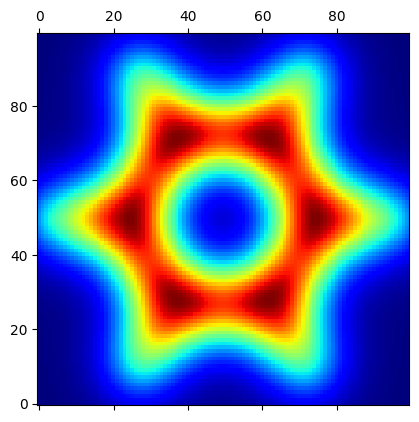

In [16]:
plt.matshow(dens0.reshape(shape),cmap='jet',origin='lower') #电子密度

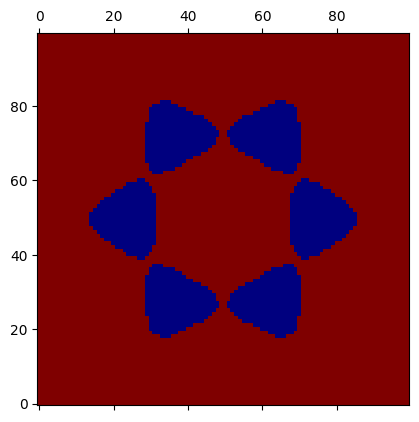

In [17]:
plt.matshow((np.linalg.norm(dens1,axis=1)<=0.2).reshape(shape),cmap='jet',origin='lower') #电子密度

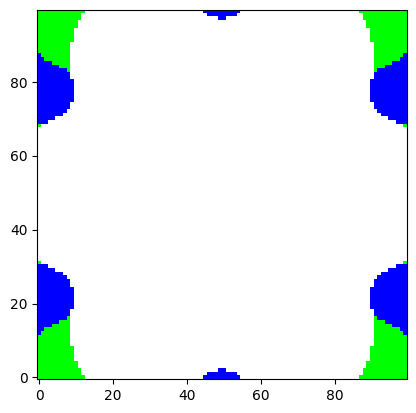

In [18]:

s=np.zeros((100,100))
w=np.zeros((100,100))
img=np.zeros((100,100,3))
for i in range(100):
    for j in range(100):
        Hess=dens2[i*100+j]
        eigval,eigvec=np.linalg.eigh(Hess)
        rank=[1 if abs(e)>1e-6 else  0 for e in eigval]
        syms=[1 if e>0         else -1 for e in eigval]
        if np.linalg.norm(dens1[i*100+j])>1e-2:
            img[i,j]=[1,1,1]
            continue
        match sum(rank),sum(syms):
            case 3,-3: 
                img[i,j]=[1,0,0] # 核临界点
            case 3,-1:
                img[i,j]=[0,1,0] # 键临界点
            case 3,1:
                img[i,j]=[0,0,1] # 环临界点
            case 3,3:
                img[i,j]=[0,0,0] # 笼临界点
            case _:
                img[i,j]=[1,1,1] # 其它点
        # img[i,j]=eigval

plt.imshow(img,origin='lower')

In [34]:
# 迭代搜索键临界点
def show_type(Hessian):
    eigval,eigvec=np.linalg.eigh(Hessian)
    rank=[1 if abs(e)>1e-6 else  0 for e in eigval]
    syms=[1 if e>0         else -1 for e in eigval]
    print(sum(rank),sum(syms))

bond=[1,2]
pos0=(mol.atom(bond[0]).coord+mol.atom(bond[1]).coord)/2+np.random.rand(3) #初始点
print(pos0)
for i in range(100):
    dens0,dens1,dens2=caler.molDens(pos0.reshape(1,3),level=2) #计算电子密度，电子密度梯度和电子密度Hessian矩阵
    Hessian=dens2[0] #取出Hess矩阵
    eigvals,eigvecs=np.linalg.eigh(Hessian) #计算Hess矩阵的特征值和特征向量
    if np.abs(np.linalg.det(Hessian)) < 1e-10:
        x,y,z=pos0
        print(f'Hessian is singular at :{x:>10.4f},{y:>10.4f},{z:>10.4f}')
        print(dens0[0])
        print(dens1[0])
        print(Hessian)
        show_type(Hessian)
        break
    if np.linalg.norm(dens1[0]) < 1e-6:
        print(dens1[0])
        show_type(Hessian)
        break
    delta = np.linalg.solve(Hessian, dens1[0])
    pos0 -= delta
    print(i,pos0,np.linalg.norm(dens1[0]))

[1.4373 2.3919 0.8342]
0 [1.8908 2.9456 2.0024] 0.2042729910364422
1 [2.058  3.1504 2.4349] 0.024329248575089495
2 [2.3238 3.3564 2.8798] 0.009165497513098763
3 [2.6795 3.5924 3.3112] 0.0034902012775438595
Hessian is singular at :    2.6795,    3.5924,    3.3112
0.0005478605532489513
[-0.0003 -0.0006 -0.001 ]
[[0.0002 0.0002 0.0005]
 [0.0002 0.0005 0.0011]
 [0.0005 0.0011 0.0015]]
3 1


In [20]:
mol.coords

array([[-0.    ,  2.6483,  0.    ],
       [ 2.2935,  1.3241,  0.    ],
       [ 2.2935, -1.3241,  0.    ],
       [ 0.    , -2.6483,  0.    ],
       [-2.2935, -1.3241,  0.    ],
       [-2.2935,  1.3241,  0.    ],
       [-0.    ,  4.6703,  0.    ],
       [ 4.0446,  2.3351,  0.    ],
       [ 4.0446, -2.3351,  0.    ],
       [ 0.    , -4.6703,  0.    ],
       [-4.0446, -2.3351,  0.    ],
       [-4.0446,  2.3351,  0.    ]], dtype=float32)

In [21]:
for bond in mol.bonds:
    print(bond)

  1-  2,  2.648262
  1-  6,  2.648262
  1-  7,  2.022007
  2-  3,  2.648262
  2-  8,  2.022007
  3-  4,  2.648262
  3-  9,  2.022007
  4-  5,  2.648262
  4- 10,  2.022007
  5-  6,  2.648262
  5- 11,  2.022007
  6- 12,  2.022007


(26, 3)


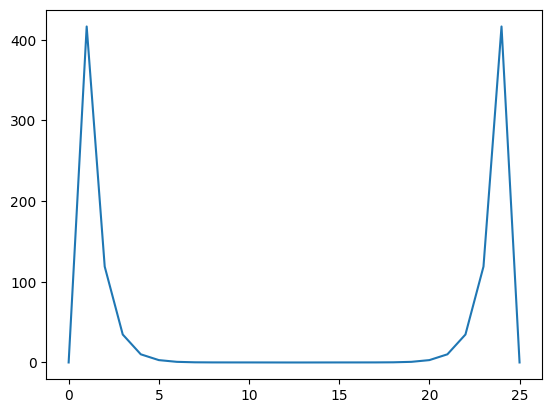

In [22]:
from pywfn.gridprop import LineGrid
p0=mol.atom(1).coord
p1=mol.atom(2).coord
shape,grids=LineGrid().set(p0,p1,0.1).get()
caler=density.Calculator(mol)
dens0,dens1,dens2=caler.molDens(grids,level=2)
print(dens1.shape)
dists=np.linalg.norm(dens1,axis=1)
plt.plot(dists)